# Create a GAN (Generative adversarial network)
## Take random noise and generate an output

In [125]:
import tensorflow as tf

# from tensorflow.keras.layers import Dense

### Get mnist dataset

In [126]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

(60000, 28, 28)


### Data normalizing

In [127]:
# add grayscale color channel
train_images = train_images.reshape(60000, 28, 28, 1)
print(train_images.shape)

# normalizing data between -1 and 1
train_images = (train_images - 127.5)/127.5

(60000, 28, 28, 1)


In [128]:
SHUFFLE_SIZE = 60000
BATCH_SIZE = 25

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = train_ds.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)

### Define model

In [129]:
# Discriminator

from tensorflow.keras.layers import Dense, Conv2D, LeakyReLU, Dropout, Flatten

D = tf.keras.models.Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
           input_shape=(28, 28, 1)),
    LeakyReLU(),
    Dropout(0.3),

    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),

    Flatten(),
    Dense(1, activation='sigmoid')
    ])

/Users/andrewlou/Documents/Coding/NYU-Machine-Learning/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [130]:
# Generator

from tensorflow.keras.layers import BatchNormalization, Reshape, Conv2DTranspose

G = tf.keras.Sequential([
    Dense(7*7*256, use_bias=False, input_shape=(100, )),
    BatchNormalization(),
    LeakyReLU(),
    
    Reshape((7, 7, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),


    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False),

])

/Users/andrewlou/Documents/Coding/NYU-Machine-Learning/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [131]:
G.output_shape

(None, 28, 28, 1)

### Visualizing output

Generated image shape: (1, 28, 28, 1)


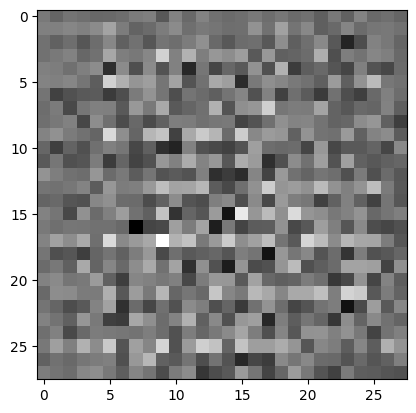

In [132]:
import matplotlib.pyplot as plt

noise = tf.random.normal([1, 100])
generated_image = G(noise, training=False)

print(f"Generated image shape: {generated_image.shape}")

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [133]:
decision = D(generated_image)
print(decision)

tf.Tensor([[0.49992716]], shape=(1, 1), dtype=float32)


### Define losses

In [134]:
def d_loss(d_output_real, d_output_fake):
    cross_entropy = tf.keras.losses.BinaryCrossentropy()
    # discriminator predicts 1 for real images, 0 for fake images

    # create vector of 1s same shape as d_output_real
    ones_vector = tf.ones_like(d_output_real)
    real_loss = cross_entropy(d_output_real, ones_vector)

    # create vector of 0s same shape as d_output_fake
    zero_vector = tf.zeros_like(d_output_fake)
    fake_loss = cross_entropy(d_output_fake, zero_vector)

    loss = real_loss + fake_loss
    return loss

def g_loss(d_output_fake):
    # Train the generator such that fake images it creates
    # Get predicted as 1 by the discriminator (Trick the discriminator)
    cross_entropy = tf.keras.losses.BinaryCrossentropy()

    zeros_vector = tf.zeros_like(d_output_fake)
    loss = cross_entropy(d_output_fake, zeros_vector)

    return loss

### Define gradient step, using custom losses

In [135]:
# Gradient descent, training

@tf.function
def train_step(images, G, D, g_loss, d_loss, g_opt, d_opt, noise_dim=100):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = G(noise, training=True)

        d_output_real = D(images)
        d_output_fake = D(generated_images)

        gen_loss = g_loss(d_output_fake)
        disc_loss = d_loss(d_output_real, d_output_fake)

    # Generate gradients using loss functions
    grad_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)

    # Apply gradients
    g_opt.apply_gradients(zip(grad_generator, G.trainable_variables))
    d_opt.apply_gradients(zip(grad_discriminator, D.trainable_variables))


### Adam optimizers

In [136]:
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)

In [137]:

def generate_save_images(model, epoch, test_input):
    # test input is of size (batch_size, 100) maybe (16, 100)
    prediction = model(test_input)
    plt.figure(figsize=(4, 4))

    for i in range(prediction.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(prediction[i, :, :, 0], cmap='grey')
        plt.axis('off')

    plt.savefig(f"image_at_epoch_{epoch}.png")
    plt.show()


### Training loop

In [138]:
import time
from IPython import display


def train(dataset, epochs, G=G, D=D, g_loss=g_loss, d_loss=d_loss, g_opt=g_opt, d_opt=d_opt):
    seed = tf.random.normal([16, 100])

    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:
            train_step(img_batch, G, D, g_loss, d_loss, g_opt, d_opt)
            display.clear_output(wait=True)
            generate_save_images(G, epoch, seed)

        end = time.time()
        print(f"Time for epoch {epoch} = {end - start}")
        print(f"Completed epoch {epoch}")

KeyboardInterrupt: 

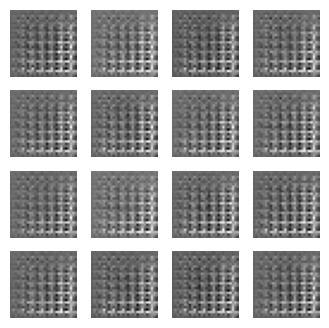

In [139]:
train(train_ds, epochs=50)